# CEIA - 16Co2024 - Visión por Computadora 1 - TP2

**Myrna L. Degano (a1618)**  
**Gustavo J. Rivas (a1620)** 

## Objetivo

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. 
El video a procesar será: “focus_video.mov”.

In [137]:
#!pip install numpy
#!pip install opencv-python
#!pip install matplotlib

In [138]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## 1.

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper ["Image Sharpness Measure for Blurred Images in Frequency Domain“](./papers/ImageSharpnessMeasureforBlurredImagesinFrequency.pdf) y realizar tres experimentos:

1.Medición sobre todo el frame.  
2.Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.  
3.Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados.   
N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

Para cada experimento se debe presentar :  
-Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.  
-Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.  


In [139]:
# El documento propone una nueva técnica para calcular la medida 
# de nitidez/desenfoque de la imagen en el dominio de la frecuencia.
# FM - Frequency Domain Image Blur Measure (Métrica de calidad de la imagen)
def getFM(I):
    """
    Obtiene la métrica FM para medir la calidad de la imagen
    Input: imagen (I) de tamaño M×N
    Output: Métrica de calidad de la imagen (FM)
    Medida de desenfoque de imagen en el dominio de frecuencia.
    """
    # Paso 1 - Calcular F, que es la representación de la transformada de Fourier de la imagen I.
    F = np.fft.fft2(I)
    
    # Paso 2 - Encontrar Fc que se obtiene desplazando el origen de F al centro.
    Fc = np.fft.fftshift(F)
    
    # Paso 3 - Calcular AF=abs (Fc) 
    # AF es el valor absoluto de la transformada de Fourier centrada de la imagen I.
    # Magnitud del espectro
    AF = np.abs(Fc)

    # Paso 4 - Calcular M = max (AF) 
    # M es el valor máximo de la componente de frecuencia en F.
    M = np.max(AF)
    
    # Paso 5 - Calcular TH = el número total de píxeles en F 
    # cuyo (valor de píxel) > umbral
    # donde umbral = M/1000.
    TH = np.sum(AF > (M/1000))

    # Paso 6 - Calcular la métrica FM
    # FM = TH / (MxN)
    m, n = I.shape
   
    return TH / (m*n) 

In [140]:
def showFrame(img, title=''):
    """
    Muestra una imagen en RGB
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('on')
    plt.show()

In [141]:
def showGraph(x, y, title, labelx, labely,     
                props = {
                    'linestyle': '-', 
                    'color': 'b'
                }):

    """
    Muestra gráfico de líneas
    Marcando el punto máximo
    Devuelve coordenadas del máximo
    """
    plt.figure(figsize=(7, 5))
    plt.plot(x, y, **props)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    
    xMax, yMax = getMaxXY(y)
    plt.plot(xMax, yMax, 'r*', label=f"Máximo enfoque \n - Frame#: {xMax:.0f}\n - FM: {yMax:.5f}")  
    plt.axhline(y=yMax, color='red', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='red', linestyle='--', linewidth=0.5)  
    plt.legend(loc='best')
    plt.grid(False)
    plt.show()

    return xMax, yMax

In [142]:
def getROI(img, shape=[1,1], pos=[0,0]):
    """
    Toma una imagen y la longitud en x e y
    Devuelve la región de interés de las dimensiones especificadas
    Puntos de vértice del rectángulo
    """
    return img[pos[0]:pos[0] + shape[0], pos[1]:pos[1] + shape[1]], (pos[1], pos[0]), (pos[1] + shape[1], pos[0] + shape[0])


In [143]:
def getMaxXY(arr):
    """
    Devuelve las coordenadas del valor máximo
    a partir de los valores de Y
    """
    max_index = np.argmax(arr)

    x_max = max_index + 1
    y_max = arr[max_index]

    return x_max, y_max

In [144]:
def getDims(shapeXY, p_area=10, position=['c', 'c']):
    """
    Devuelve las dimensiones del recorte
    Inputs:
    - dimensiones totales [M, N]
    - porcentaje del área total
    - posición del recorte (centro por default)
    Outputs:
    - dimensiones 
    - coordenadas de posición inicial del recorte
    """
    area = shapeXY[0]*shapeXY[1]*(p_area/100)

    # Mantener a misma relación de aspecto
    # shapeXY[0] / shapeXY[1]
    rows = min(int(np.sqrt(area * (shapeXY[0] / shapeXY[1]))), shapeXY[0])
    columns = min(int(np.sqrt(area * (shapeXY[1] / shapeXY[0]))), shapeXY[1])

    row, col = position
    center = [shapeXY[0]//2, shapeXY[1]//2]
        
    if row == 'c':
        # reemplazar por el centro de filas
        row = center[0] - rows//2

    if col == 'c':
        # reemplazar por el centro de columnas
        col = center[1] - columns//2

    return [rows, columns], [row, col]


In [145]:
def getFocusMatrix(image, M, N):
    """
    Toma una imagen y los valore M y N
    Devuelve matriz de MxN
    Con la imagen dividida en rectángulos
    """
    rows, cols = image.shape
        
    focusMatrix = []
    
    # tamaño de cada rectángulo
    rectRows = rows // M
    rectCols = cols // N

    for i in range(M):
        focusRows = []
        for j in range(N):
            # Calcular los límites de cada porción
            left = j * rectCols            
            top = i * rectRows
            right = left + rectCols
            bottom = top + rectRows

            # Ajustar si queda un residuo fuera de la división
            # Para considerar la imagen completa
            if i == M - 1:
                bottom = rows
            if j == N - 1:
                right = cols
                
            # Recortar la porción de la imagen
            rect = image[top:bottom, left:right]

            focusRows.append(rect)
        focusMatrix.append(focusRows)

    return focusMatrix

In [146]:
def printFrameNum(img, num, c, s):
    """
    Agrega el número de frame
    """
    cv.putText(img, f'FRAME {num}', (50, 50), cv.FONT_HERSHEY_SIMPLEX, s, c, 2, cv.LINE_AA)

    return img

In [147]:
def printRectangle(img, pt1, pt2, c, s):
    """
    Agregar rectángulo del área de interés
    """
    cv.rectangle(img, pt1, pt2, c, s, cv.LINE_8)

    return img

In [173]:
def showVideo(path, title, props):
    
    try:    
        video_capture = cv.VideoCapture(path)
        timer=0
        
        if not video_capture.isOpened():
            print("Error al abrir el archivo de video")
        else:
            # tasa de cuadros (frame rate) del video
            fps = int(video_capture.get(cv.CAP_PROP_FPS))
            normal_delay = int(1000 / fps)
            delay = normal_delay    
            
            i=0
            while True:
                ret, frame = video_capture.read()
                if not ret:
                    break
                i = i + 1

                if props['max'] == i:
                    color= (0, 255, 0)
                    size = 1
                    delay = normal_delay * 50
                else:
                    color = (0, 0, 255)
                    size = 1
                    delay = normal_delay

                if props['frames']:
                    #imprime número de frame
                    new_frame = printFrameNum(frame, i, color, size)
                elif props['roi']:
                    # Imprime rectángulo
                    new_frame = printRectangle(frame, props['roi'][0], props['roi'][1], color, size)
                    new_frame = printFrameNum(new_frame, i, color, size)
                else:
                    # Imprime frame original sin alterar
                    new_frame = frame
                    
                cv.imshow(title, new_frame)
                
                # Salir del loop si se presiona la tecla 'q'
                if cv.waitKey(delay) & 0xFF == ord('q'):
                    break
    finally:    
        # Liberar recursos
        video_capture.release()
        cv.destroyAllWindows()

In [149]:
video_path = 'video/focus_video.mov'

In [168]:
showVideo(video_path, title='Video Original', props={'frames': False, 'max': 0, 'roi': False})

In [153]:
# Lectura del video
try:
    video_capture = cv.VideoCapture(video_path)
    video_frames = []
    video_fm = []
    
    if not video_capture.isOpened():
        print("Error al abrir el archivo de video")
    else:
        while True:
            ret, frame = video_capture.read()
            if ret:
                # guardar los frames para procesamiento posterior
                video_frames.append(frame)
            else:
                break
finally:                
    video_capture.release()
    cv.destroyAllWindows()

### 1.1 Medición sobre todo el frame

In [154]:
# Por cada frame del video:
for frame in video_frames:
    # Convertir a escala de grises
    frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calcular métrica y almacenar para gráfico
    video_fm.append(getFM(frame_g))


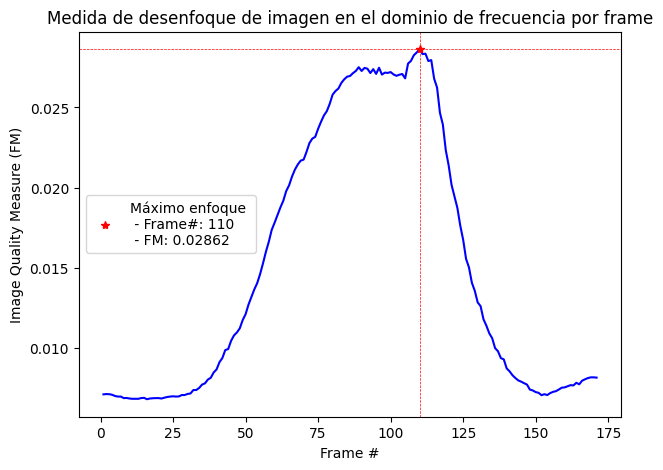

In [155]:
xMax, yMax = showGraph(list(range(1, len(video_fm) + 1)), video_fm, 
          'Medida de desenfoque de imagen en el dominio de frecuencia por frame', 
          'Frame #', 
          'Image Quality Measure (FM)')


In [157]:
showVideo(video_path, title='Video - Enfoque - Frame Completo', props={'frames': True, 
                                                                       'max': xMax})

### 2.1 Medición sobre una ROI ubicada en el centro del frame.

In [169]:
percent = [5, 10, 20, 50, 100] # Porcentajes del área total
video_fm = {z: [] for z in percent}
roi_points = {z: [] for z in percent}

# Para los recortes establecidos
for p in percent:

    # Por cada frame del video:
    for frame in video_frames:
        # Convertir a escala de grises
        frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Obtener región de interés - dimensiones y posición
        roiShape, roiP = getDims(frame_g.shape, p, ['c', 'c'])
        frame_roi, p1, p2 = getROI(frame_g, roiShape, roiP)

        # Calcular métrica y almacenar para gráfico
        video_fm[p].append(getFM(frame_roi))
        # Guardar los puntos para dibujar rectángulo
        roi_points[p]=[p1, p2]

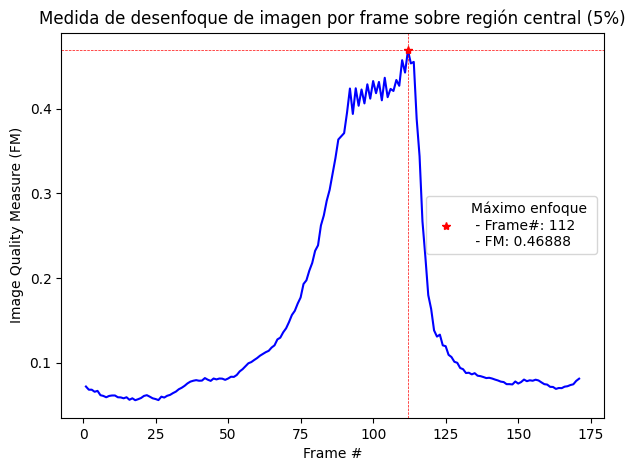

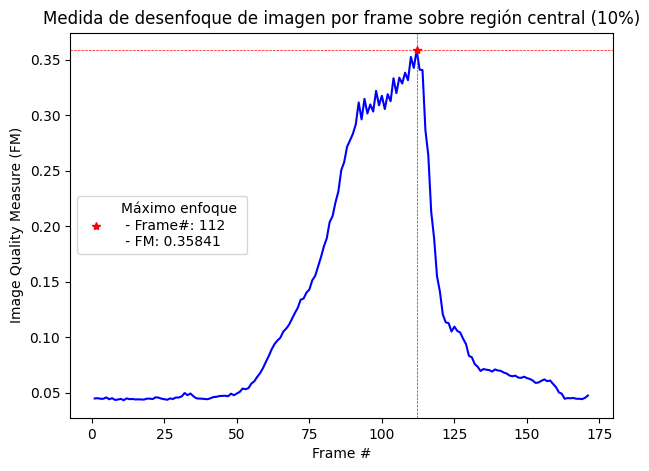

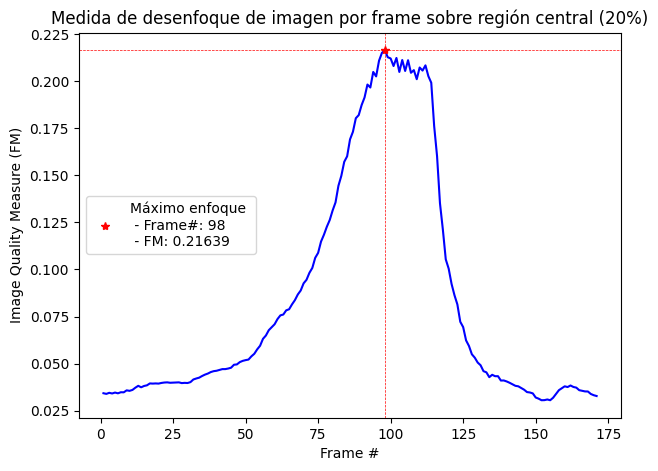

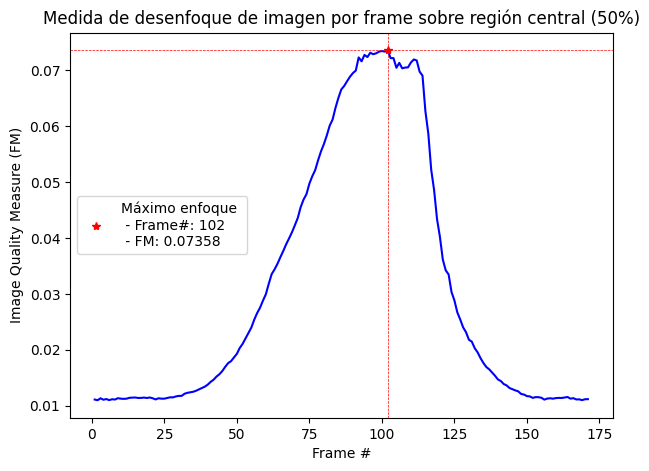

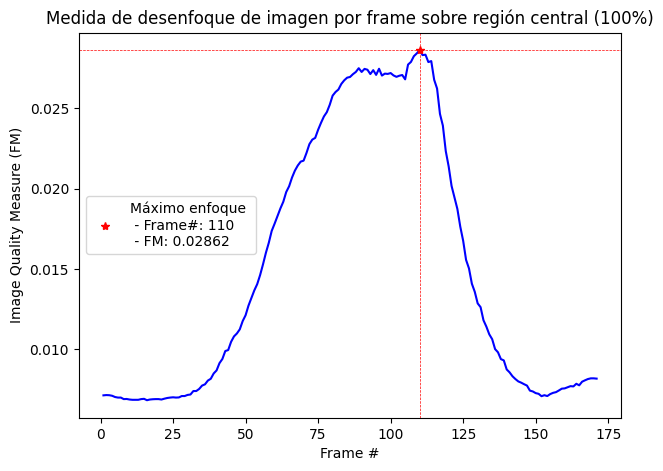

In [170]:
for p in percent:
    showGraph(list(range(1, len(video_fm[p]) + 1)), video_fm[p], 
          f'Medida de desenfoque de imagen por frame sobre región central ({p}%)', 
          'Frame #', 
          'Image Quality Measure (FM)')


Tomamos los frames entre 75 y 125 para graficar juntas de forma comparativa las diferentes curvas.

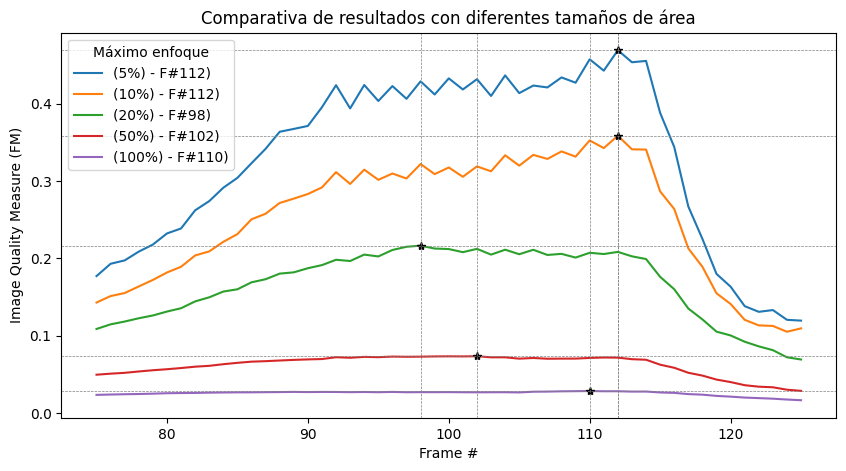

In [171]:
plt.figure(figsize=(10, 5))
_from = 75
_to = 125
roi_max = {}

for p in percent:
    xMax = _from + np.argmax(video_fm[p][_from:_to+1]) + 1
    yMax = video_fm[p][xMax-1]
    roi_max[p] = xMax
    
    plt.plot(list(range(_from, _to+1)), video_fm[p][_from-1:_to], 
             label=f'({p}%) - F#{xMax})')

    plt.plot(xMax, yMax, 'k*')  
    plt.axhline(y=yMax, color='gray', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='gray', linestyle='--', linewidth=0.5)  


plt.title('Comparativa de resultados con diferentes tamaños de área')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')
plt.legend(title='Máximo enfoque')
plt.show()

In [174]:
for p in percent:

    showVideo(video_path, title=f'Video - Enfoque - ROI ({p}%)', 
          props={'frames': False, 'roi': roi_points[p], 'max': roi_max[p] })


### 1.3 Medición con matriz de enfoque

In [27]:
# Diferentes tamaños de matrices de enfoque
focusMxs = [
    (3, 3),
    (7, 5),
    (2, 4),
    (10, 5),
    (1, 1)
    ] 
fmFrame = {}
video_fm = {z: [] for z in focusMxs}

# Para los tamaños de matriz prestablecidos
for (focusM, focusN) in focusMxs:

    # Indice - Dimensiones de la matriz de enfoque
    iM = f"{focusM}x{focusN}"
    # Contiene por cada matriz
    # promedio del frame y array con métricas parciales
    fmFrame[iM] = []

    # Por cada frame del video:
    for frame in video_frames:
        # Convertir a escala de grises
        frame_g = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
        # Obtener las porciones de la imagen
        fMx = getFocusMatrix(frame_g, focusM, focusN)
        fmAux = [] # Métricas parciales del frame
        for xRow in fMx:
            for xCol in xRow:
                # Calcular la métrica por cada porción
                fmAux.append(getFM(xCol))

        # Promediar para encontrar una única métrica por frame
        fmFrame[iM].append(np.mean(fmAux))


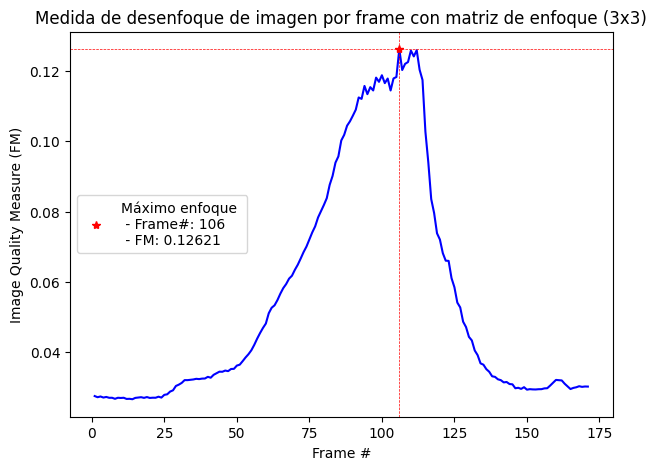

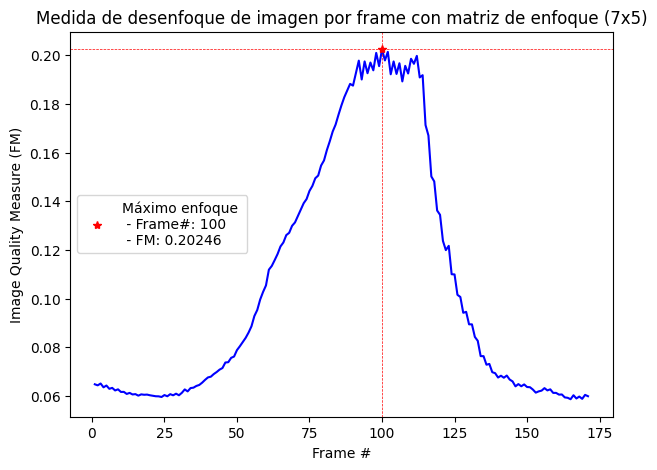

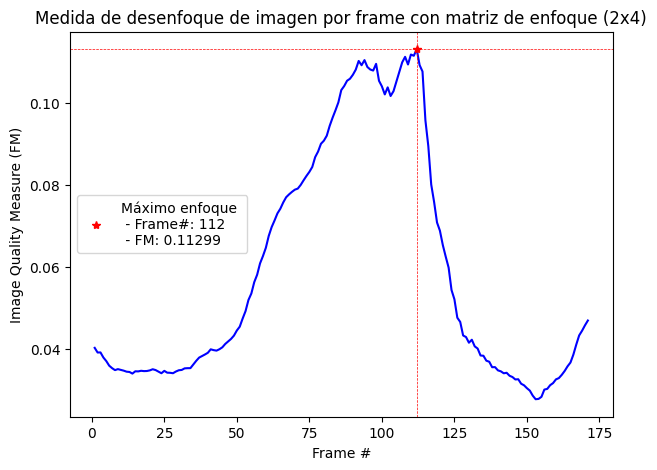

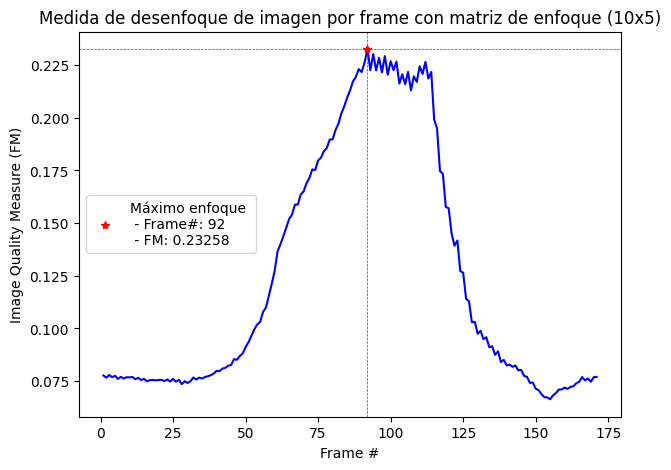

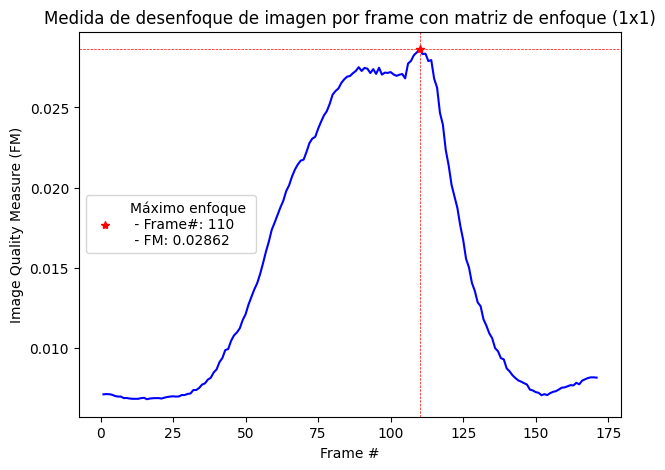

In [28]:
for iM in fmFrame.keys():
    showGraph(list(range(1, len(fmFrame[iM]) + 1)), fmFrame[iM], 
          f'Medida de desenfoque de imagen por frame con matriz de enfoque ({iM})', 
          'Frame #', 
          'Image Quality Measure (FM)')


Tomamos los frames entre 75 y 125 para graficar juntas de forma comparativa las diferentes curvas.


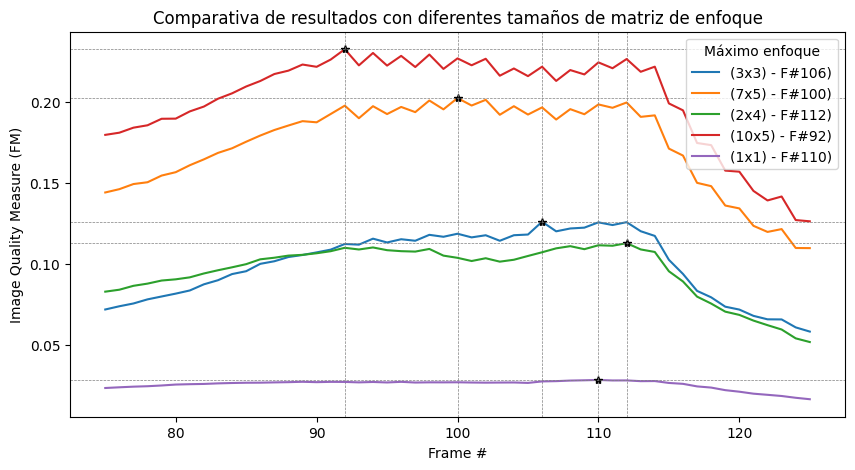

In [29]:
plt.figure(figsize=(10, 5))
_from = 75
_to = 125

for iM in fmFrame.keys():

    xMax = _from + np.argmax(fmFrame[iM][_from:_to+1]) + 1
    yMax = fmFrame[iM][xMax-1]
    
    plt.plot(list(range(_from, _to+1)), fmFrame[iM][_from-1:_to], 
             label=f'({iM}) - F#{xMax})')

    plt.plot(xMax, yMax, 'k*')  
    plt.axhline(y=yMax, color='gray', linestyle='--', linewidth=0.5)  
    plt.axvline(x=xMax, color='gray', linestyle='--', linewidth=0.5)  


plt.title('Comparativa de resultados con diferentes tamaños de matriz de enfoque')
plt.xlabel('Frame #')
plt.ylabel('Image Quality Measure (FM)')
plt.legend(title='Máximo enfoque')
plt.show()


## 2.

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: ["Analysis of focus measure operators in shapefrom focus"](./papers/AnalysisOfFocusMeasureOperators.pdf).
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.

## Adicional

Aplicar unsharp masking para expandir la zona de enfoque y devolver.